In [1]:
import requests, zipfile
import urllib
from io import BytesIO
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from langdetect import detect

from nltk.tokenize import WhitespaceTokenizer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
np.random.seed(69)

In [3]:
# Import the data

df_training = pd.read_csv(r"mediaeval-2015-trainingset.txt", sep="\t")
df_testing = pd.read_csv(r"mediaeval-2015-testset.txt", sep="\t")

# Data analysis

In [4]:
df_training.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


In [5]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


In [6]:
df_training['label'].value_counts()

fake     6742
real     4921
humor    2614
Name: label, dtype: int64

In [7]:
df_testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int64(2), object(5)
memory usage: 205.5+ KB


imageId(s)
sandyA                9695
sandyB                2621
boston                 546
malaysia               501
sochi                  402
columbianChemicals     185
bringback              131
underwater             112
passport                46
pigFish                 14
elephant                13
livr                     9
Name: tweetId, dtype: int64


<IPython.core.display.Javascript object>


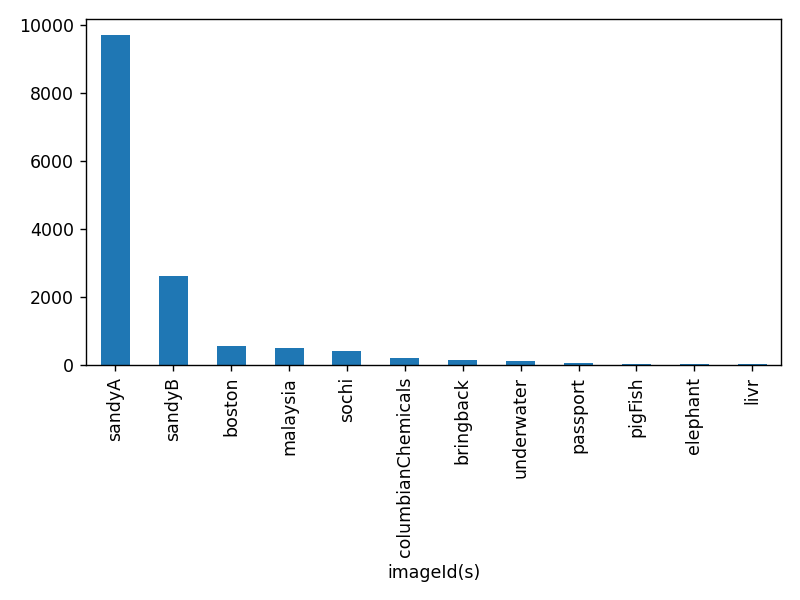

In [8]:
# Use the image names to determine events mentioned and their frequencies
# Sort in descending order
event_frequency = df_training.groupby(df_training['imageId(s)'].str.split('_').str[0])['tweetId'].nunique()
event_frequency = event_frequency.sort_values(ascending=False)
print(event_frequency)

# Plot a bar chart of the frequencies
%matplotlib notebook
event_frequency.plot(kind='bar')
plt.tight_layout()

imageId(s)
syrianboy     1769
nepal         1353
eclipse        277
samurai        218
garissa         77
varoufakis      61
Name: tweetId, dtype: int64


<IPython.core.display.Javascript object>


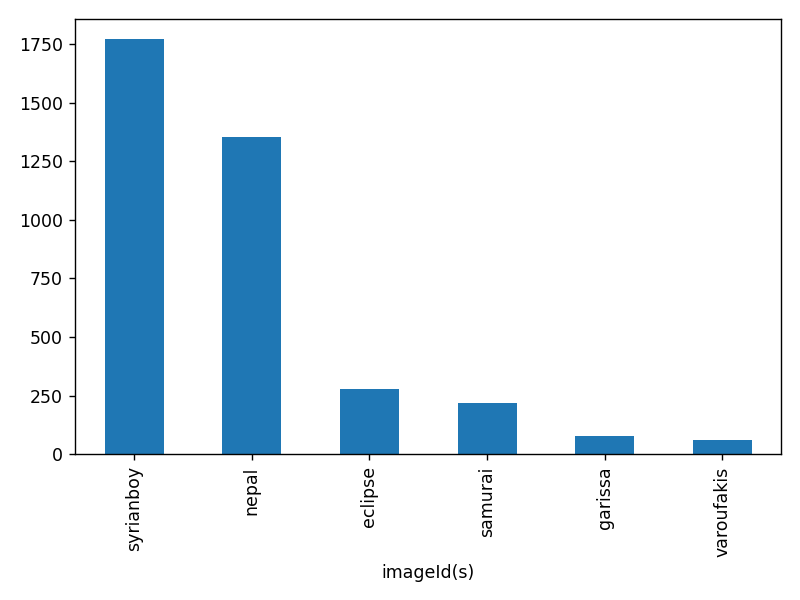

In [57]:
# Use the image names to determine events mentioned and their frequencies
# Sort in descending order
event_frequency = df_testing.groupby(df_testing['imageId(s)'].str.split('_').str[0])['tweetId'].nunique()
event_frequency = event_frequency.sort_values(ascending=False)
print(event_frequency)

# Plot a bar chart of the frequencies
%matplotlib notebook
event_frequency.plot(kind='bar')
plt.tight_layout()

In [29]:
# Create empty dictionary to count word occurences in testing data
training_language_count = dict()

# Attempt to identify language of each tweet and update dictionary for each instance
# If can not detect language then increment 'Unknown'
for tweet_text in df_training['tweetText']:
    try:
        language = detect(tweet_text)
    except:
        language = 'Unknown'
    
    if language in training_language_count.keys():
        training_language_count[language] += 1
    else:
        training_language_count[language] = 1
        
print(training_language_count)

{'es': 1292, 'en': 10975, 'sq': 9, 'ru': 63, 'it': 100, 'no': 36, 'pl': 37, 'fr': 212, 'bg': 9, 'ro': 6, 'nl': 87, 'pt': 161, 'de': 130, 'tl': 332, 'cy': 112, 'id': 173, 'sv': 42, 'ja': 21, 'ar': 80, 'vi': 12, 'ca': 34, 'hu': 7, 'so': 131, 'fi': 13, 'af': 58, 'da': 21, 'sk': 14, 'el': 5, 'he': 1, 'hr': 3, 'ko': 8, 'sw': 11, 'tr': 28, 'zh-cn': 11, 'fa': 3, 'sl': 7, 'et': 8, 'th': 18, 'cs': 1, 'lt': 2, 'mk': 1, 'Unknown': 1, 'hi': 1, 'lv': 1}


In [30]:
# Create empty dictionary to count word occurences in testing data
testing_language_count = dict()

# Attempt to identify language of each tweet and update dictionary for each instance
# If can not detect language then increment 'Unknown'
for tweet_text in df_testing['tweetText']:
    try:
        language = detect(tweet_text)
    except:
        language = 'Unknown'
    
    if language in testing_language_count.keys():
        testing_language_count[language] += 1
    else:
        testing_language_count[language] = 1
        
print(testing_language_count)

{'en': 2789, 'fr': 34, 'es': 58, 'ca': 6, 'it': 19, 'pt': 40, 'nl': 22, 'fi': 4, 'id': 7, 'ar': 187, 'af': 5, 'hr': 1, 'tr': 12, 'hi': 5, 'ta': 1, 'el': 3, 'tl': 3, 'pl': 2, 'sq': 4, 'te': 2, 'ru': 2, 'th': 2, 'sv': 2, 'so': 488, 'vi': 2, 'ko': 2, 'ja': 3, 'ro': 1, 'bg': 1, 'cy': 5, 'lt': 1, 'de': 41, 'da': 1}


# Preprocessing

In [31]:
# Change the humour label to the fake label
df_training.loc[df_training.label=='humor', 'label'] = 'fake'
df_testing.loc[df_testing.label=='humor', 'label'] = 'fake'

In [32]:
# Function for removing substrings from tweets
def remove_pattern(tweet_text, pattern):
    return re.sub(pattern, '', tweet_text)

In [33]:
# Remove URLs
url_pattern1 = r'http\S+'
url_pattern2 = r'\\\/\S+'

def remove_url1(tweet_text):
    return remove_pattern(tweet_text, url_pattern1)

def remove_url2(tweet_text):
    return remove_pattern(tweet_text, url_pattern2)

df_training['tweetText'] = df_training['tweetText'].apply(remove_url1)
df_training['tweetText'] = df_training['tweetText'].apply(remove_url2)

In [34]:
# Remove @ mentions
username_pattern = r'@\w+'
def remove_username(tweet_text):
    return remove_pattern(tweet_text, username_pattern)

df_training['tweetText'] = df_training['tweetText'].apply(remove_username)

In [35]:
# Remove symbols
newline_pattern = r'&amp;|\\n'
def remove_newline(tweet_text):
    return remove_pattern(tweet_text, newline_pattern)

df_training['tweetText'] = df_training['tweetText'].apply(remove_newline)

In [36]:
# Remove emojis
def remove_emojis(tweet_text):
    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"    # Unicode values for emojis
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', tweet_text)

df_training['tweetText'] = df_training['tweetText'].apply(remove_emojis)

In [37]:
# Change all text to lower case
# df_training['tweetText'] = [tweet_text.lower() for tweet_text in df_training['tweetText']]

# Removed as resulted in lower accuracy

In [38]:
# Remove stopwords
stopword_list = stopwords.words()

def remove_stopwords(tweet_text):
    words = []
    for word in tweet_text.split():
        if word not in stopword_list:
            words.append(word)
    return ' '.join(words)

df_training['importantText'] = df_training['tweetText'].apply(remove_stopwords)

In [39]:
# Tokenise and lemmatise the tweet text
tokeniser = WhitespaceTokenizer()
lemmatiser = WordNetLemmatizer()

def lemmatise_text(tweet_text):
    tokenised_text = tokeniser.tokenize(tweet_text)
    lemmatised_text = [lemmatiser.lemmatize(word) for word in tokenised_text]
    return ' '.join(lemmatised_text)

df_training['lemmatisedText'] = df_training['importantText'].apply(lemmatise_text)

In [40]:
df_training.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,importantText,lemmatisedText
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake,¿Se acuerdan película: “El día después mañana”...,¿Se acuerdan película: “El día después mañana”...
1,262995061304852481,: Miren a Sandy en NY! Tremenda imagen del hu...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake,: Miren Sandy NY! Tremenda imagen huracán. Par...,: Miren Sandy NY! Tremenda imagen huracán. Par...
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake,"Buena foto Huracán Sandy, recuerda película Dí...","Buena foto Huracán Sandy, recuerda película Dí..."
3,262996108400271360,Scary shit #hurricane #NY,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake,Scary shit #hurricane #NY,Scary shit #hurricane #NY
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake,My fave place world #nyc #hurricane #sandy #st...,My fave place world #nyc #hurricane #sandy #st...


# Algorithm design

In [41]:
# Set up training predictor and target variables

training_predictor = df_training['lemmatisedText']
training_target = df_training['label']

In [42]:
# Set up testing predictor and target variables

testing_predictor = df_testing['tweetText']
testing_target = df_testing['label']

In [43]:
# Function to calculate F1 score and print results

def f1_score(prediction):
    TP, FP, TN, FN = 0, 0, 0, 0
    
    for prediction, target in zip(prediction, testing_target):
        if prediction == 'fake':
            if target == 'fake':
                TP += 1
            elif target == 'real':
                FP += 1
        elif prediction == 'real':
            if target == 'fake':
                FN += 1
            elif target == 'real':
                TN +=1
            
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    print('TP: ' + str(TP) + ' FP: ' + str(FP) + ' TN: ' + str(TN) + ' FN: ' + str(FN))
    print('F1 score: ' + str(f1))
    
    return [f1, TP, FP, TN, FN]

### Bag of words

In [44]:
# Create the bag of words for training/testing data

bow_vectoriser = CountVectorizer(stop_words='english')
bow_vectoriser.fit(df_training['lemmatisedText'])

training_bow = bow_vectoriser.transform(training_predictor)
testing_bow = bow_vectoriser.transform(testing_predictor)

In [45]:
# Train multinomial Naive-Bayes model
multi_nb = naive_bayes.MultinomialNB()
multi_nb.fit(training_bow, training_target)

# Predict labels for testing data
multi_nb_pred = multi_nb.predict(testing_bow)

# Print the results
print('Multinomial Naive-Bayes accuracy score: ', accuracy_score(multi_nb_pred, testing_target) * 100)
multi_nb_bow_R = f1_score(multi_nb_pred)
print(multi_nb_bow_R)

Multinomial Naive-Bayes accuracy score:  51.93075898801598
TP: 923 FP: 182 TN: 1027 FN: 1623
F1 score: 0.5056149000273897
[0.5056149000273897, 923, 182, 1027, 1623]


In [46]:
# Train Passive-Aggressive model
passive_aggressive = PassiveAggressiveClassifier()
passive_aggressive.fit(training_bow, training_target)

# Predict labels for testing data}
passive_aggressive_pred = passive_aggressive.predict(testing_bow)

# Print the results
print('Passive Aggressive accuracy score: ', accuracy_score(passive_aggressive_pred, testing_target) * 100)
passive_aggressive_bow_R = f1_score(passive_aggressive_pred)

Passive Aggressive accuracy score:  81.03861517976031
TP: 2095 FP: 261 TN: 948 FN: 451
F1 score: 0.8547531619747043


In [47]:
# Tune hyperparameters and train SVM
param_grid = {'C': [0.5, 0.6],
              'gamma': [1, 0.1, 0.001],
             'kernel': ['linear'],
             'degree': [3]}

svm_grid = GridSearchCV(svm.SVC(), param_grid)
svm_grid.fit(training_bow, training_target)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.5, 0.6], 'degree': [3],
                         'gamma': [1, 0.1, 0.001], 'kernel': ['linear']})

In [48]:
print(svm_grid.best_params_)
svm_pred = svm_grid.predict(testing_bow)
print('SVM accuracy score: ', accuracy_score(svm_pred, testing_target) * 100)
svm_bow_R = f1_score(svm_pred)

{'C': 0.5, 'degree': 3, 'gamma': 1, 'kernel': 'linear'}
SVM accuracy score:  72.54327563249001
TP: 2303 FP: 788 TN: 421 FN: 243
F1 score: 0.8171012950150789


### TF-IDF

In [49]:
# Vectorise the words with TF-IDF

tfidf_vectoriser = TfidfVectorizer(stop_words='english', max_df=0.1)
tfidf_vectoriser.fit(df_training['lemmatisedText'])

training_tfidf = tfidf_vectoriser.transform(training_predictor)
testing_tfidf = tfidf_vectoriser.transform(testing_predictor)

In [50]:
# Train multinomial Naive-Bayes model with TF-IDF
multi_nb = naive_bayes.MultinomialNB()
multi_nb.fit(training_tfidf, training_target)

# Predict labels for testing data
multi_nb_pred = multi_nb.predict(testing_tfidf)

print("Multinomial Naive Bayes accuracy score : ", accuracy_score(multi_nb_pred, testing_target) * 100)
multi_nb_tfidf_R = f1_score(multi_nb_pred)

Multinomial Naive Bayes accuracy score :  85.67243675099867
TP: 2297 FP: 289 TN: 920 FN: 249
F1 score: 0.8951675759937646


In [51]:
# Train Passive-Aggressive model
passive_aggressive = PassiveAggressiveClassifier()
passive_aggressive.fit(training_tfidf, training_target)

# Predict labels for testing data
passive_aggressive_pred = passive_aggressive.predict(testing_tfidf)

# Print the results
print('Passive Aggressive accuracy score: ', accuracy_score(passive_aggressive_pred, testing_target) * 100)
passive_aggressive_tfidf_R = f1_score(passive_aggressive_pred)

Passive Aggressive accuracy score:  82.29027962716378
TP: 2118 FP: 237 TN: 972 FN: 428
F1 score: 0.8643134054274637


In [52]:
# Tune hyperparameters and train SVM
param_grid = {'C': [1.0, 1.1, 1.2],
              'gamma': [1, 0.1, 0.001],
             'kernel': ['linear'],
             'degree': [3]}

svm_grid = GridSearchCV(svm.SVC(), param_grid)
svm_grid.fit(training_tfidf, training_target)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1.0, 1.1, 1.2], 'degree': [3],
                         'gamma': [1, 0.1, 0.001], 'kernel': ['linear']})

In [53]:
# Print the best parameters for the model
print(svm_grid.best_params_)

# Predict on testing data
svm_pred = svm_grid.predict(testing_tfidf)

# Print results
print('SVM accuracy score: ', accuracy_score(svm_pred, testing_target) * 100)
svm_tfidf_R = f1_score(svm_pred)

{'C': 1.1, 'degree': 3, 'gamma': 1, 'kernel': 'linear'}
SVM accuracy score:  85.1398135818908
TP: 2325 FP: 337 TN: 872 FN: 221
F1 score: 0.8928571428571429


# Evaluation

<IPython.core.display.Javascript object>


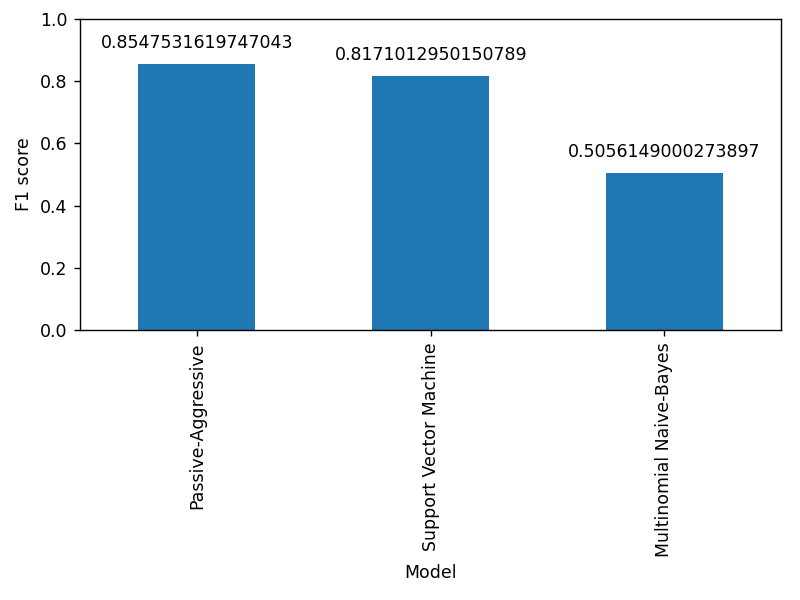

In [56]:
# Create dataframe in descending order of models to F1 scores for bag of words
model_list = ['Multinomial Naive-Bayes', 'Passive-Aggressive', 'Support Vector Machine']
f1_list_bow = [multi_nb_bow_R[0], passive_aggressive_bow_R[0], svm_bow_R[0]]
results_bow = pd.DataFrame(zip(model_list, f1_list_bow), columns=['Model', 'F1'])
f1_list_bow.sort(reverse=True)
results_bow = results_bow.sort_values(by='F1', ascending=False)

# Display results in bar chart
%matplotlib notebook
results_bow.plot(kind='bar', x='Model', y='F1', legend=False)
plt.tight_layout()
plt.ylim([0,1])
plt.ylabel('F1 score')
plt.subplots_adjust(left=0.1)

for i in range(3):
    plt.text(i, f1_list_bow[i] + 0.05, f1_list_bow[i], ha='center')

<IPython.core.display.Javascript object>


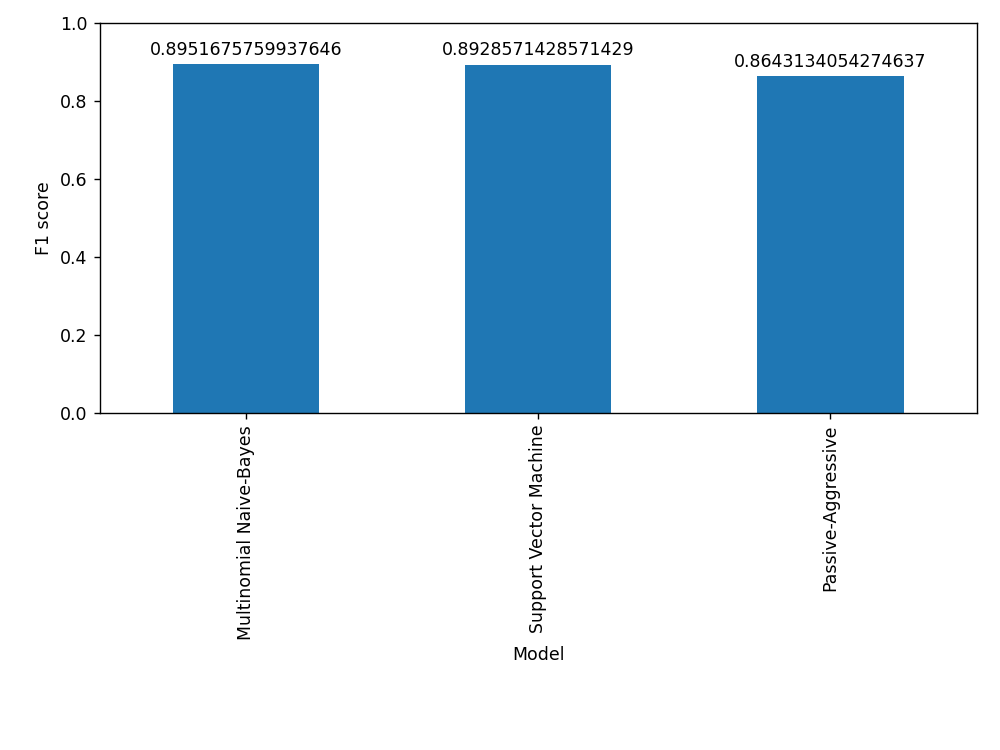

In [55]:
# Create dataframe in descending order of models to F1 scores for bag of words
model_list = ['Multinomial Naive-Bayes', 'Passive-Aggressive', 'Support Vector Machine']
f1_list_tfidf = [multi_nb_tfidf_R[0], passive_aggressive_tfidf_R[0], svm_tfidf_R[0]]
results_tfidf = pd.DataFrame(zip(model_list, f1_list_tfidf), columns=['Model', 'F1'])
f1_list_tfidf.sort(reverse=True)
results_tfidf = results_tfidf.sort_values(by='F1', ascending=False)

# Display results in bar chart
%matplotlib notebook
results_tfidf.plot(kind='bar', x='Model', legend=False)
plt.tight_layout()
plt.ylim([0,1])
plt.ylabel('F1 score')
plt.subplots_adjust(left=0.1)

for i in range(3):
    plt.text(i, f1_list_tfidf[i] + 0.025, f1_list_tfidf[i], ha='center')